# Version 2 - Only augmentation

## 1. Imports

In [1]:
import os

import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from PIL import Image
from IPython.display import display

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from tqdm import tqdm

## 2. Setup data

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
## set the path to train and test set
##data_path =<path>
## drive location
## for colab set the folders in colab root folder
#<zip file location>
##!unzip <path> 
data_path = '/content/chest_xray'

## 3. Explore data

In [7]:
class_name = ['NORMAL','PNEUMONIA']
def get_list_files(dirName):
    '''
    input - directory location
    output - list the files in the directory
    '''
    files_list = os.listdir(dirName)
    return files_list

files_list_normal_train = get_list_files(data_path+'/train/'+class_name[0])
files_list_pneu_train = get_list_files(data_path+'/train/'+class_name[1])

files_list_normal_test = get_list_files(data_path+'/test/'+class_name[0])
files_list_pneu_test = get_list_files(data_path+'/test/'+class_name[1])

In [8]:
print("Number of train samples in Normal category {}".format(len(files_list_normal_train)))
print("Number of train samples in Pneumonia category {}".format(len(files_list_pneu_train)))

print("Number of test samples in Normal category {}".format(len(files_list_normal_test)))
print("Number of test samples in Pneumonia category {}".format(len(files_list_pneu_test)))

Number of train samples in Normal category 1349
Number of train samples in Pneumonia category 3883
Number of test samples in Normal category 234
Number of test samples in Pneumonia category 390


(2374, 2427)


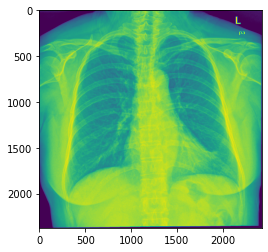

In [9]:
## get random file to check
img = data_path + '/train/NORMAL/'+ files_list_normal_train[np.random.randint(0,len(files_list_normal_train))]
print(plt.imread(img).shape)
#display(Image.open(img,'r'),)

img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

(864, 1384)


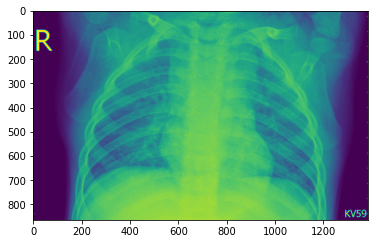

In [10]:
## get random file to check pneumona 
img = data_path + '/train/PNEUMONIA/'+ files_list_pneu_train[np.random.randint(0,len(files_list_pneu_train))]
print(plt.imread(img).shape)
#display(Image.open(img,'r'),)

img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

In [ ]:
#path_to_image = <path>

plt.imread(path_to_image).shape

(2094, 2194)

In [ ]:
cv2.imread(path_to_image).shape

(2094, 2194, 3)

In [11]:
train_transform = transforms.Compose([
    
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

In [12]:
## getting train and test data loader in place
train_data = datasets.ImageFolder(os.path.join(data_path, 'train'), transform= train_transform)
test_data = datasets.ImageFolder(os.path.join(data_path, 'test'), transform= test_transform)

train_loader = DataLoader(train_data,
                          batch_size= 4, shuffle= True, pin_memory= True)
test_loader = DataLoader(test_data, 
                         batch_size= 1, shuffle= False, pin_memory= True)

class_names = train_data.classes

print(class_names)
print(f'Number of train images: {len(train_data)}')
print(f'Number of test images: {len(test_data)}')


['NORMAL', 'PNEUMONIA']
Number of train images: 5232
Number of test images: 624


## 4. Define Model

In [13]:

import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3), 
                      padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(8)
        ) 
        self.pool11 = nn.MaxPool2d(2, 2)

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3),
                      padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(16)
        ) 

        self.pool22 = nn.MaxPool2d(2, 2) 


        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(10),
            nn.ReLU()
        ) 
        self.pool33 = nn.MaxPool2d(2, 2) 
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(10)
        )

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
           
        ) 


        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(10),
            
        )

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(10)
         
        )

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(32),
            nn.ReLU()            
        )


        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(10),
            
        ) 

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(14),
            
        ) 

        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(16),
            
        ) 
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) 

        self.convblockout = nn.Sequential(
              nn.Conv2d(in_channels=16, out_channels=2, kernel_size=(4, 4), padding=0, bias=False),

        ) 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.pool11(x)
        x = self.convblock2(x)
        x = self.pool22(x)
        x = self.convblock3(x)
        x = self.pool33(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.convblock11(x)
        x = self.gap(x)        
        x = self.convblockout(x)

        x = x.view(-1, 2)
        return F.log_softmax(x, dim=-1)


In [14]:

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Available processor {}".format(device))
model = Net().to(device)
summary(model, input_size=(3, 224, 224))

Available processor cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             216
              ReLU-2          [-1, 8, 222, 222]               0
         MaxPool2d-3          [-1, 8, 111, 111]               0
            Conv2d-4         [-1, 16, 109, 109]           1,152
              ReLU-5         [-1, 16, 109, 109]               0
         MaxPool2d-6           [-1, 16, 54, 54]               0
            Conv2d-7           [-1, 10, 54, 54]             160
              ReLU-8           [-1, 10, 54, 54]               0
         MaxPool2d-9           [-1, 10, 27, 27]               0
           Conv2d-10           [-1, 10, 25, 25]             900
             ReLU-11           [-1, 10, 25, 25]               0
           Conv2d-12           [-1, 32, 25, 25]             320
             ReLU-13           [-1, 32, 25, 25]               0
           Con

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Train and Test function

In [15]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies= []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, gradient is accumulated over backprop and even though thats used in RNN generally not used in CNN 
        # or specific requirements
        
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_accuracies.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

    test_accuracies.append(100. * correct / len(test_loader.dataset))


In [16]:


model =  Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH number:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    print('Current Learing Rate: ', optimizer.state_dict()["param_groups"][0]["lr"])
    test(model, device, test_loader)

EPOCH: 0


Loss=0.6931058168411255 Batch_id=1307 Accuracy=74.22: 100%|██████████| 1308/1308 [02:04<00:00, 10.47it/s]


current Learing Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH: 1


Loss=0.6930233836174011 Batch_id=1307 Accuracy=74.22: 100%|██████████| 1308/1308 [02:04<00:00, 10.47it/s]


current Learing Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH: 2


Loss=0.693147599697113 Batch_id=1307 Accuracy=62.69: 100%|██████████| 1308/1308 [02:03<00:00, 10.57it/s]


current Learing Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 471/624 (75.48%)

EPOCH: 3


Loss=0.6931362152099609 Batch_id=1307 Accuracy=76.76: 100%|██████████| 1308/1308 [02:05<00:00, 10.44it/s]


current Learing Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 423/624 (67.79%)

EPOCH: 4


Loss=0.6770405769348145 Batch_id=1307 Accuracy=74.03: 100%|██████████| 1308/1308 [02:06<00:00, 10.36it/s]


current Learing Rate:  0.01

Test set: Average loss: 0.6742, Accuracy: 498/624 (79.81%)

EPOCH: 5


Loss=0.6931501030921936 Batch_id=1307 Accuracy=38.28: 100%|██████████| 1308/1308 [02:06<00:00, 10.37it/s]


current Learing Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 259/624 (41.51%)

EPOCH: 6


Loss=0.6931492686271667 Batch_id=1307 Accuracy=36.18: 100%|██████████| 1308/1308 [02:09<00:00, 10.14it/s]


current Learing Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 260/624 (41.67%)

EPOCH: 7


Loss=0.6931475400924683 Batch_id=1307 Accuracy=35.44: 100%|██████████| 1308/1308 [02:05<00:00, 10.43it/s]


current Learing Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 259/624 (41.51%)

EPOCH: 8


Loss=0.6931480765342712 Batch_id=1307 Accuracy=35.23: 100%|██████████| 1308/1308 [02:05<00:00, 10.46it/s]


current Learing Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 259/624 (41.51%)

EPOCH: 9


Loss=0.6931467652320862 Batch_id=1307 Accuracy=34.79: 100%|██████████| 1308/1308 [02:03<00:00, 10.60it/s]


current Learing Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 261/624 (41.83%)

EPOCH: 10


Loss=0.6931458711624146 Batch_id=1307 Accuracy=35.21: 100%|██████████| 1308/1308 [02:03<00:00, 10.62it/s]


current Learing Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 261/624 (41.83%)

EPOCH: 11


Loss=0.6931443810462952 Batch_id=1307 Accuracy=35.74: 100%|██████████| 1308/1308 [02:04<00:00, 10.52it/s]


current Learing Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 259/624 (41.51%)

EPOCH: 12


Loss=0.6931464672088623 Batch_id=1307 Accuracy=36.24: 100%|██████████| 1308/1308 [02:04<00:00, 10.54it/s]


current Learing Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 259/624 (41.51%)

EPOCH: 13


Loss=0.6931470036506653 Batch_id=1307 Accuracy=37.04: 100%|██████████| 1308/1308 [02:05<00:00, 10.40it/s]


current Learing Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 260/624 (41.67%)

EPOCH: 14


Loss=0.6931469440460205 Batch_id=1307 Accuracy=36.14: 100%|██████████| 1308/1308 [02:05<00:00, 10.41it/s]


current Learing Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 260/624 (41.67%)



Text(0.5, 1.0, 'Test Accuracy')

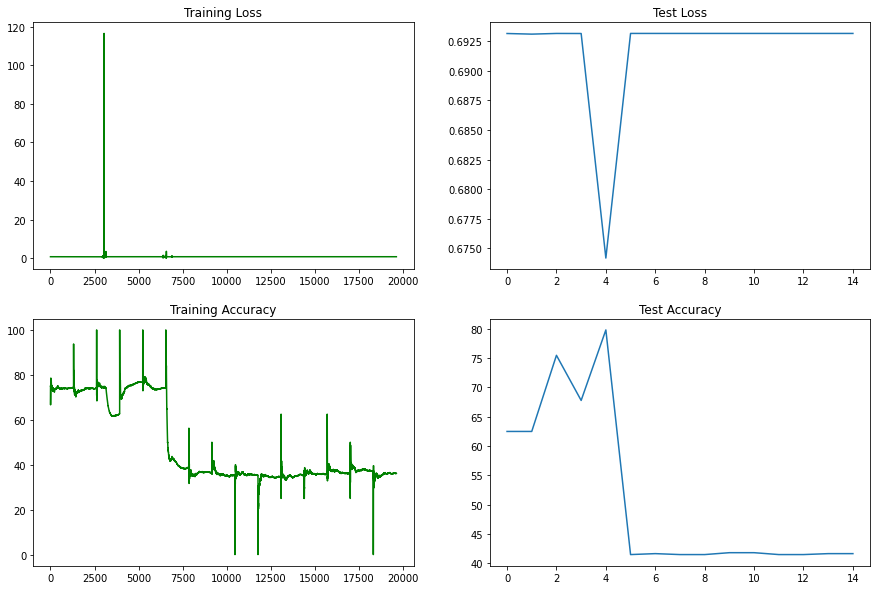

In [17]:


train_losses1 = [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc1 = [i for i in train_accuracies]
test_losses1 = [i for i in test_losses]
test_acc1 = [i for i in test_accuracies]

fig, axs = plt.subplots(2,2,figsize=(16,10))
axs[0, 0].plot(train_losses1,color='green')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc1,color='green')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses1)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc1)
axs[1, 1].set_title("Test Accuracy")